In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [3]:
f(3)

20

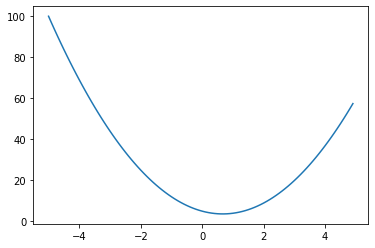

In [4]:
x_s = np.arange(-5,5,.1)
y_s = f(x_s)
plt.plot(x_s, y_s)

In [5]:
h = .0000001
x = 2/3

(f(x+h) - f(x)) / h

2.9753977059954195e-07

In [6]:
h = 1e-4

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

b+=h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)

print('slope: ',(d2 - d1) / h )

d1:  4.0
d2:  4.0002
slope:  2.0000000000042206


In [7]:
class Value:
    def __init__(self, data, _children = (), _op = '', label=''):
        
        self.data = data
        self._prev = set(_children)
        self._backward = lambda:None
        self._op = _op
        self.label = label
        self.grad = 0
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        
        other = other if isinstance (other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
        
    def __mul__(self, other):
        
        other = other if isinstance (other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return  out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        print(self,other)
        return self * (other ** -1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad       
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ),'exp')
        
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers"
        out = Value(self.data ** other, (self, ),f'**{other}')
        
        def _backward():
            self.grad += (other) * self.data**(other-1) * out.grad #exercise...
        out._backward = _backward
        
        return out
    def backward(self):
        self.grad = 1

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()


In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
a*b

Value(data=-6.0)

In [9]:
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'

In [10]:
f = Value(-2.0, label ='f')
L = d * f
L.label = 'L' 

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label,n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

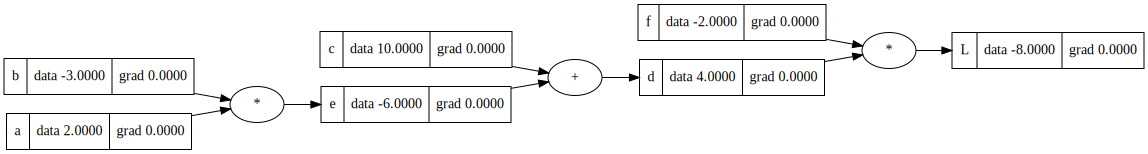

In [12]:
draw_dot(L)

In [13]:
def lol():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e+c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1 = L.data
    

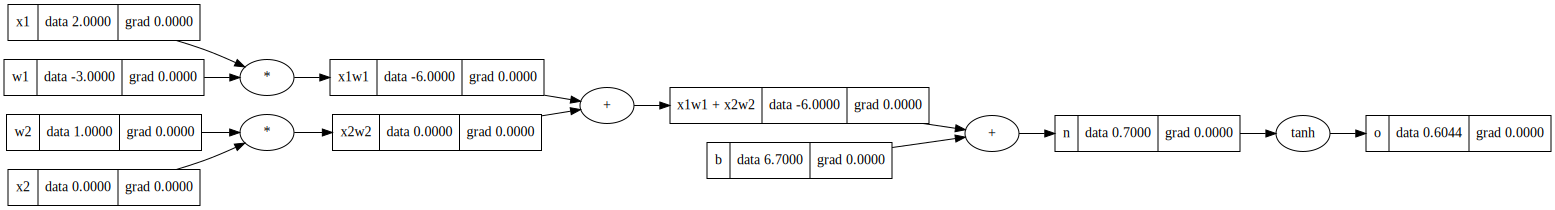

In [14]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.7, label = 'b')

#x1w1 + x2w2 + b

x1w1 = x1 * w1
x1w1.label = 'x1w1'

x2w2 = w2 * x2
x2w2.label = 'x2w2'

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = 'x1w1 + x2w2'

n = x1w1_x2w2 + b; n.label = 'n'
o = n.tanh()
o.label = 'o'
draw_dot(o)

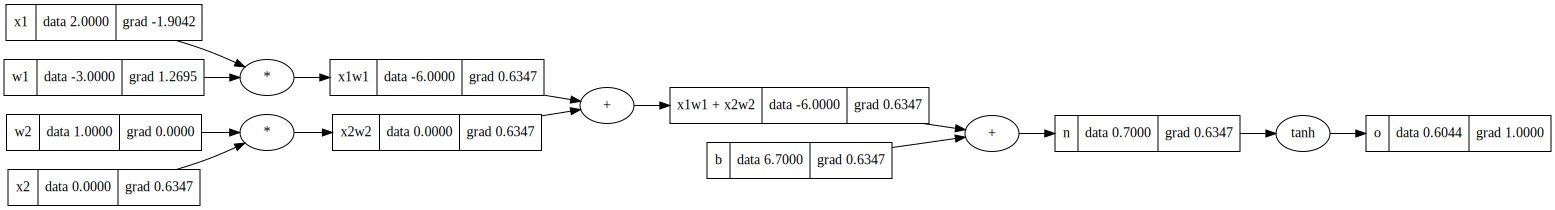

In [15]:
o.backward()
draw_dot(o)

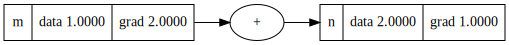

In [16]:
m = Value(1.0, label = 'm')
n = m + m; n.label = 'n'
n.backward()
draw_dot(n)

In [17]:
y = Value(2.0)
y.exp()

Value(data=7.38905609893065)

Value(data=4.8284271245183765) Value(data=6.8284271245183765)


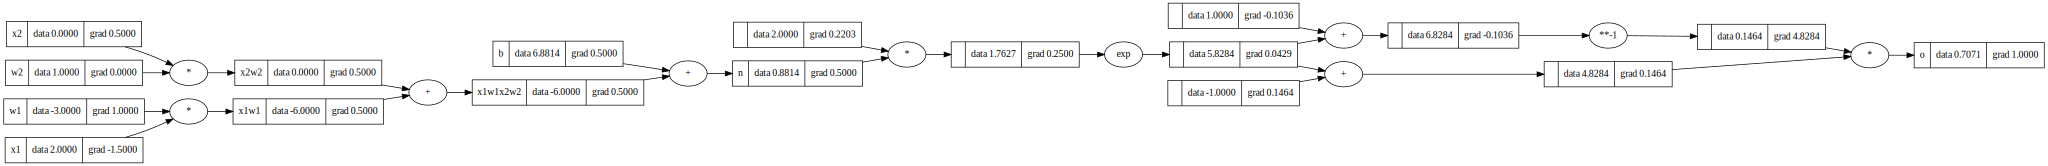

In [18]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.881373587, label = 'b')

x1w1 = x1*w1
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = 'x1w1x2w2'

n = x1w1_x2w2 + b
n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e+1)

o.label = 'o'
o.backward()
draw_dot(o)

In [21]:
import random
class Neuron:
    
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x): # m(x)
        activ = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activ.tanh()
        return out
    


In [22]:
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=0.8517304251651355),
 Value(data=-0.9994260217647173),
 Value(data=0.9990929564138872)]